# Project 3 - Sequential Classification
*Noah Trilling*

In [36]:
import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv1D, MaxPooling1D, Flatten, Dropout, SimpleRNN, Bidirectional, BatchNormalization, LSTM, ReLU
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import AdamW
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from tensorflow.keras.regularizers import l2

the_answer = 42

## Download and Explore the Data

Use Scipy’s loadmat() function to load the files, i.e. from scipy.io import loadmat. Start by loading some the recordings and plotting them.

In [10]:
mat_files = glob.glob('./training2017/*.mat')
x = [loadmat(f) for f in mat_files]

C:\Users\NoahMSOE\AppData\Local\Temp\ipykernel_1676\594223031.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


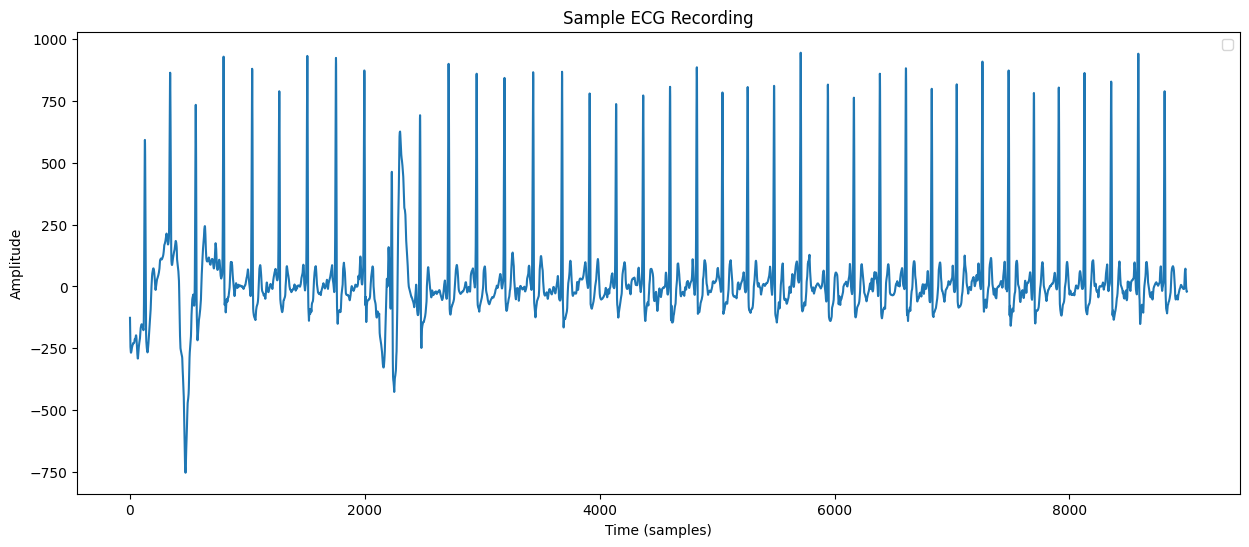

C:\Users\NoahMSOE\AppData\Local\Temp\ipykernel_1676\594223031.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


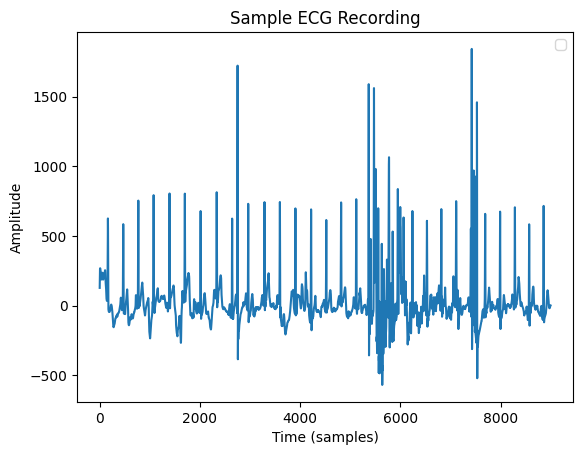

C:\Users\NoahMSOE\AppData\Local\Temp\ipykernel_1676\594223031.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


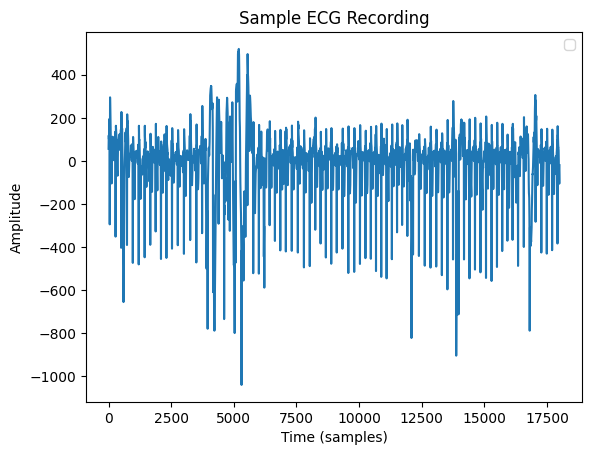

In [11]:
plt.figure(figsize=(15, 6))
for i in range(3):
    signal = x[i]['val'].squeeze()
    sns.lineplot(x=range(len(signal)), y=signal)
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.title('Sample ECG Recording')
    plt.legend()
    plt.show()


Count the total number of recordings to ensure that it matches the number given above.

In [12]:
print(f"Total number of recordings: {len(x)}")

Total number of recordings: 8528


Generate a table and count plot for the number of recordings in each category.

category
N    5050
O    2456
A     738
~     284
Name: count, dtype: int64

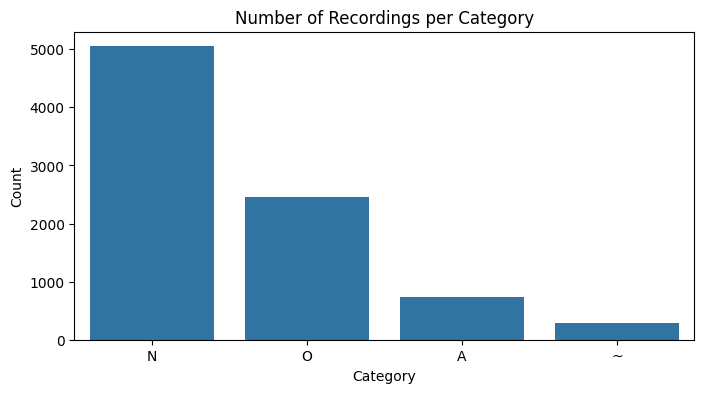

In [13]:
y_df = pd.read_csv('./training2017/REFERENCE.csv', names=['recording', 'category'])
category_counts = y_df['category'].value_counts()
display(category_counts)

plt.figure(figsize=(8, 4))
sns.countplot(x='category', data=y_df, order=category_counts.index)
plt.title('Number of Recordings per Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

Look at the distribution of lengths of the recordings – are they the same?

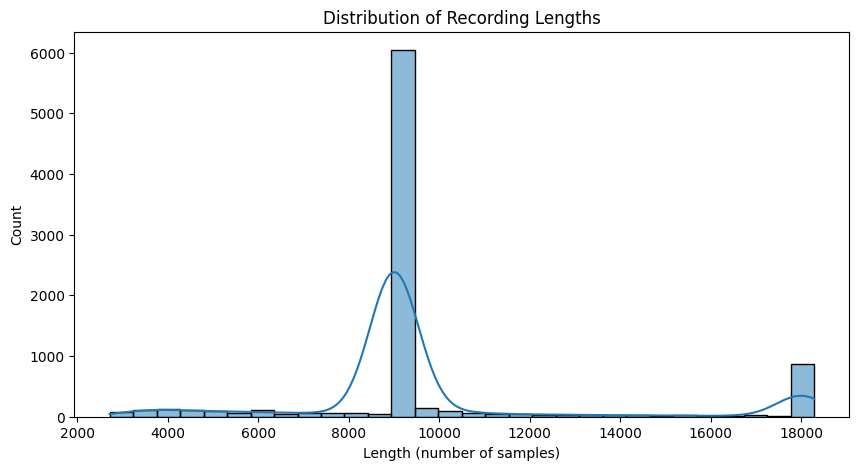

In [14]:
lengths = [d['val'].shape[1] for d in x]

plt.figure(figsize=(10, 5))
sns.histplot(lengths, bins=30, kde=True)
plt.title('Distribution of Recording Lengths')
plt.xlabel('Length (number of samples)')
plt.ylabel('Count')
plt.show()

## Build several machine learning models to classify this data

### Data Preprocessing

The ECG sequences are not the same length. There are model architectures available for dealing with sequences of arbitrary length, but for simplicity we will preprocess these sequences so that they have the same length. There are many possible ways to do this, for example:

Pad the end of each sequence with zeros to make it the length of the longest
overall sequence;

Take the first t data points for each sequence, where t is the length of the
shortest sequence;

Sample a window of each sequence of length t, where t is less than or equal to the length of the shortest sequence;

Choose and implement a strategy for making the sequences the same length.

In [15]:
median_len = int(np.median(lengths))

x = np.array([
    np.pad(d['val'].squeeze()[:median_len], (0, max(0, median_len - d['val'].squeeze().shape[0])), mode='constant')
    for d in x
])

input_length = x.shape[1]
print(f"Input length after padding: {input_length}")

Input length after padding: 9000


Split the data into training, validation, and testing sets.

In [16]:
y = y_df['category'].values

categories = sorted(np.unique(y))
category_to_index = {cat: idx for idx, cat in enumerate(categories)}
index_to_category = {idx: cat for cat, idx in category_to_index.items()}

x_mean = x.mean(axis=1, keepdims=True)
x_std = x.std(axis=1, keepdims=True)
x = (x - x_mean) / (x_std + 1e-8)

x_train, x_temp, y_train, y_temp = train_test_split(
    x, y, test_size=0.2, random_state=the_answer, stratify=y
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=the_answer, stratify=y_temp
)

y_train = np.array([category_to_index[label] for label in y_train])
y_val = np.array([category_to_index[label] for label in y_val])
y_test = np.array([category_to_index[label] for label in y_test])

num_classes = len(np.unique(y_train))

### Dense Neural Network

Use Keras to build a dense NN to classify these sequences. Begin with a single hidden layer. Use accuracy as your metric and Adam as your optimizer.

In [ ]:
model = Sequential([
    Input(shape=(input_length,)),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4749 - loss: 1.6828 - val_accuracy: 0.4748 - val_loss: 1.5192
Epoch 2/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6546 - loss: 0.8937 - val_accuracy: 0.4994 - val_loss: 1.4382
Epoch 3/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7335 - loss: 0.6957 - val_accuracy: 0.5193 - val_loss: 1.4428
Epoch 4/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7962 - loss: 0.5165 - val_accuracy: 0.5041 - val_loss: 1.6237
Epoch 5/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8424 - loss: 0.4241 - val_accuracy: 0.5170 - val_loss: 1.7594
Epoch 6/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8713 - loss: 0.3597 - val_accuracy: 0.5006 - val_loss: 1.9673
Epoch 7/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8953 - loss: 0.2956 - val_accuracy: 0.4971 - val_loss: 2.1452
Epoch 8/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9128 - loss: 0.2620 - val_accuracy: 0.

#### DNN Metrics

All the metrics should be generated after predicting on the testing set.

In [ ]:
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Compute the F1 score for each class.

In [ ]:
f1_per_class = f1_score(y_test, y_pred, average=None)
for idx, score in enumerate(f1_per_class):
    print(f"F1 score for class {index_to_category[idx]}: {score}")

F1 score for class A: 0.14193548387096774
F1 score for class N: 0.6243996157540826
F1 score for class O: 0.30022075055187636
F1 score for class ~: 0.03508771929824561


Compute and report the overall F1 score as the average of the computed F1 scores.

In [ ]:
overall_f1 = np.mean(f1_per_class)
print(f"Overall F1 score (average across classes): {overall_f1:.4f}")

Overall F1 score (average across classes): 0.2754


Report the AUC score.

In [ ]:
auc_score = roc_auc_score(y_test, y_pred_probs, average='macro', multi_class='ovr')
print(f"AUC score (macro, one-vs-rest): {auc_score:.4f}")

AUC score (macro, one-vs-rest): 0.5495


Also, construct confusion matrices.

<Figure size 600x600 with 0 Axes>

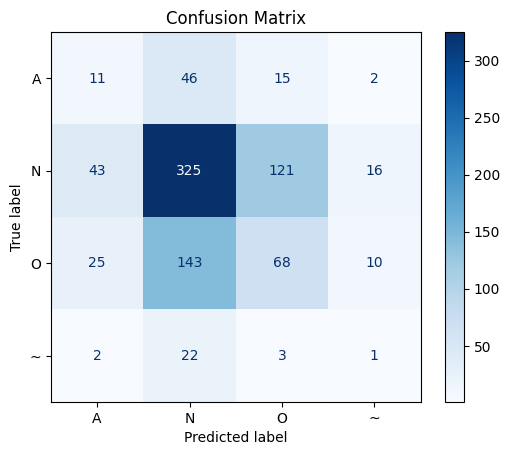

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[index_to_category[idx] for idx in range(num_classes)])
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

### Convolutional Neural Network

Use Keras to build a second deep learning model, using convolutional neural
networks, to classify these sequences. Use accuracy as your metric and Adam as your
optimizer.

In [ ]:
cnn_model = Sequential([
    Input(shape=(input_length, 1)),
    Conv1D(32, kernel_size=7, activation='relu'),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 32s 142ms/step - accuracy: 0.4938 - loss: 3.2020 - val_accuracy: 0.5826 - val_loss: 1.0230
Epoch 2/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 30s 138ms/step - accuracy: 0.6599 - loss: 0.8619 - val_accuracy: 0.5909 - val_loss: 1.0683
Epoch 3/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 30s 139ms/step - accuracy: 0.7082 - loss: 0.7289 - val_accuracy: 0.5346 - val_loss: 1.1315
Epoch 4/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - accuracy: 0.7710 - loss: 0.5914 - val_accuracy: 0.5346 - val_loss: 1.2108
Epoch 5/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 30s 142ms/step - accuracy: 0.8173 - loss: 0.4877 - val_accuracy: 0.5006 - val_loss: 1.4117
Epoch 6/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 29s 137ms/step - accuracy: 0.8398 - loss: 0.3999 - val_accuracy: 0.5322 - val_loss: 1.6843
Epoch 7/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 30s 142ms/step - accuracy: 0.8660 - loss: 0.3267 - val_accuracy: 0.4924 - val_loss: 1.8697
Epoch 8/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 30s 142ms/step - accuracy: 0.9069 - loss: 0

#### CNN Metrics

All the metrics should be generated after predicting on the testing set.

In [ ]:
cnn_y_pred_probs = cnn_model.predict(x_test)
cnn_y_pred = np.argmax(cnn_y_pred_probs, axis=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


Compute the F1 score for each class.

In [ ]:
cnn_f1_per_class = f1_score(y_test, cnn_y_pred, average=None)
for idx, score in enumerate(cnn_f1_per_class):
    print(f"F1 score for class {index_to_category[idx]}: {score}")

F1 score for class A: 0.11570247933884298
F1 score for class N: 0.592
F1 score for class O: 0.29601518026565465
F1 score for class ~: 0.06896551724137931


Compute and report the overall F1 score as the average of the computed F1 scores.

In [ ]:
cnn_overall_f1 = np.mean(cnn_f1_per_class)
print(f"Overall F1 score (average across classes): {cnn_overall_f1:.4f}")

Overall F1 score (average across classes): 0.2682


Report the AUC score.

In [ ]:
cnn_auc_score = roc_auc_score(y_test, cnn_y_pred_probs, average='macro', multi_class='ovr')
print(f"CNN AUC score (macro, one-vs-rest): {cnn_auc_score:.4f}")

CNN AUC score (macro, one-vs-rest): 0.5526


Also, construct confusion matrices.

<Figure size 600x600 with 0 Axes>

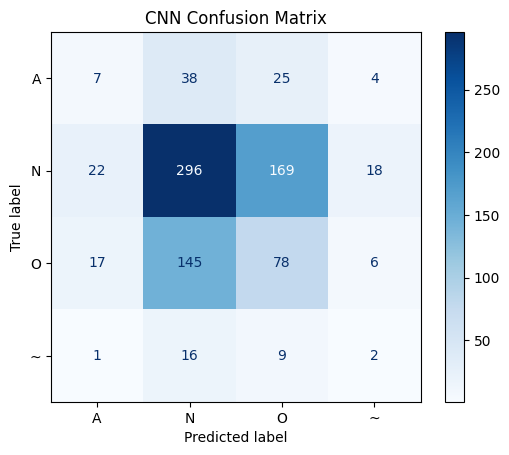

In [ ]:
cnn_cm = confusion_matrix(y_test, cnn_y_pred)
cnn_disp = ConfusionMatrixDisplay(confusion_matrix=cnn_cm, display_labels=[index_to_category[idx] for idx in range(num_classes)])
plt.figure(figsize=(6, 6))
cnn_disp.plot(cmap='Blues', values_format='d')
plt.title('CNN Confusion Matrix')
plt.show()

### Alternative Model

Use Keras to build another machine learning model of your choice to classify these sequences.

In [ ]:
rnn_model = Sequential([
    Input(shape=(input_length, 1)),
    SimpleRNN(16, return_sequences=False),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

rnn_history = rnn_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=5,
    batch_size=32
)

Epoch 1/5
 38/214 ━━━━━━━━━━━━━━━━━━━━ 2:48 959ms/step - accuracy: 0.2831 - loss: 1.3908

KeyboardInterrupt: 

#### Alternative Model Metrics

All the metrics should be generated after predicting on the testing set.

In [ ]:
rnn_y_pred_probs = rnn_model.predict(x_test)
rnn_y_pred = np.argmax(rnn_y_pred_probs, axis=1)

Compute the F1 score for each class.

In [ ]:
rnn_f1_per_class = f1_score(y_test, rnn_y_pred, average=None)
for idx, score in enumerate(rnn_f1_per_class):
    print(f"F1 score for class {index_to_category[idx]}: {score}")

Compute and report the overall F1 score as the average of the computed F1 scores.

In [ ]:
rnn_overall_f1 = np.mean(rnn_f1_per_class)
print(f"Overall F1 score (average across classes): {rnn_overall_f1:.4f}")

Report the AUC score.

In [ ]:
rnn_auc_score = roc_auc_score(y_test, rnn_y_pred_probs, average='macro', multi_class='ovr')
print(f"RNN AUC score (macro, one-vs-rest): {rnn_auc_score:.4f}")

Also, construct confusion matrices.

In [ ]:
rnn_cm = confusion_matrix(y_test, rnn_y_pred)
rnn_disp = ConfusionMatrixDisplay(confusion_matrix=rnn_cm, display_labels=[index_to_category[idx] for idx in range(num_classes)])
plt.figure(figsize=(6, 6))
rnn_disp.plot(cmap='Blues', values_format='d')
plt.title('CNN Confusion Matrix')
plt.show()

### Optimization

Optimize your models by experimenting with different choices of model architectures, hyperparameters, and/or regularization techniques.

In [33]:
def evaluate_model(model):
    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    f1_per_class = f1_score(y_test, y_pred, average=None)
    for idx, score in enumerate(f1_per_class):
        print(f"F1 score for class {index_to_category[idx]}: {score}")
    overall_f1 = np.mean(f1_per_class)
    print(f"Overall F1 score (average across classes): {overall_f1:.4f}")
    auc_score = roc_auc_score(y_test, y_pred_probs, average='macro', multi_class='ovr')
    print(f"AUC score (macro, one-vs-rest): {auc_score:.4f}")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[index_to_category[idx] for idx in range(len(index_to_category))])
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

In [34]:
def oversample_with_resample_no_noisy(x_train, y_train, class_indexes_to_omit):
    x_oversampled = []
    y_oversampled = []

    classes, counts = np.unique(y_train, return_counts=True)
    max_count = max(counts)

    for cls in classes:
        x_cls = x_train[y_train == cls]
        y_cls = y_train[y_train == cls]

        if cls in class_indexes_to_omit:
            x_up, y_up = x_cls, y_cls
        else:
            x_up, y_up = resample(x_cls, y_cls,
                                  replace=True,
                                  n_samples=max_count,
                                  random_state=the_answer)
            # Add Gaussian noise to upsampled data
            noise = np.random.normal(loc=0.0, scale=0.03, size=x_up.shape)
            x_up = x_up + noise

        x_oversampled.append(x_up)
        y_oversampled.append(y_up)

    x_bal = np.concatenate(x_oversampled)
    y_bal = np.concatenate(y_oversampled)

    indices = np.random.permutation(len(x_bal))
    return x_bal[indices], y_bal[indices]

classes_to_omit = ['~', 'N']
class_indexes_to_omit = [category_to_index[cls] for cls in classes_to_omit]
x_train_bal, y_train_bal = oversample_with_resample_no_noisy(x_train, y_train, class_indexes_to_omit)

In [37]:
dnn_model_improved = Sequential([
    Input(shape=(input_length,)),
    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
dnn_model_improved.compile(optimizer=AdamW(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
dnn_model_improved.summary()
dnn_history = dnn_model_improved.fit(
    x_train_bal, y_train_bal,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                │ (None, 64)             │       576,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 578,660 (2.21 MB)

 Trainable params: 578,468 (2.21 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/20
 60/193 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2954 - loss: 1.8296

KeyboardInterrupt: 

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
F1 score for class A: 0.15384615384615385
F1 score for class N: 0.5917753259779338
F1 score for class O: 0.2956521739130435
F1 score for class ~: 0.0
Overall F1 score (average across classes): 0.2603
AUC score (macro, one-vs-rest): 0.5273


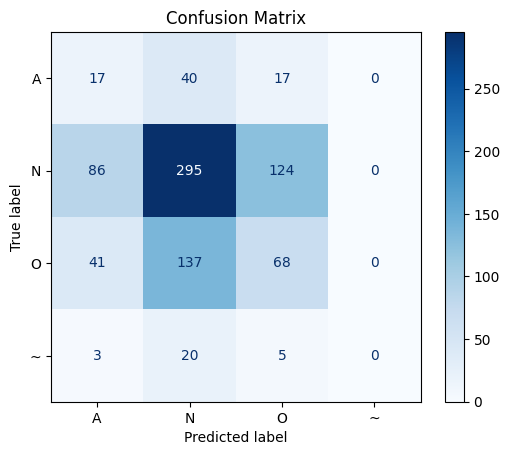

In [32]:
evaluate_model(dnn_model_improved)

In [38]:
cnn_model_improved = Sequential([
    Input(shape=(input_length, 1)),
    Conv1D(32, kernel_size=7, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling1D(2),
    Conv1D(64, kernel_size=5, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
cnn_model_improved.compile(optimizer=AdamW(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model_improved.summary()
cnn_history_improved = cnn_model_improved.fit(
    x_train_bal, y_train_bal,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)              │ (None, 9000, 32)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 9000, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 9000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 4500, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 4500, 64)       │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 4500, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 4500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 2250, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 144000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │     9,216,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,227,268 (35.20 MB)

 Trainable params: 9,227,076 (35.20 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/20


KeyboardInterrupt: 

In [ ]:
evaluate_model(cnn_model_improved)

In [ ]:
rnn_model_improved = Sequential([
    Input(shape=(input_length, 1)),
    Conv1D(64, kernel_size=5, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling1D(2),
    Conv1D(128, kernel_size=7, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling1D(2),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
rnn_model_improved.compile(optimizer=AdamW(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn_model_improved.summary()
rnn_history_improved = rnn_model_improved.fit(
    x_train_bal, y_train_bal,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_27 (Conv1D)              │ (None, 9000, 64)       │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 9000, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_21 (ReLU)                 │ (None, 9000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 4500, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 4500, 128)      │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 4500, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_22 (ReLU)                 │ (None, 4500, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_27 (MaxPooling1D) │ (None, 2250, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 338,500 (1.29 MB)

 Trainable params: 338,116 (1.29 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/20
